# Import

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, brier_score_loss
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
import lightgbm as lgbm

seed = 42
random.seed(seed)
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [2]:
df = pd.read_csv('./data/newdata.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 864
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   淋巴清扫       865 non-null    int64  
 1   总体生存时间（月）  865 non-null    float64
 2   生存状态       865 non-null    int64  
 3   feature1   865 non-null    int64  
 4   feature2   865 non-null    int64  
 5   feature3   865 non-null    int64  
 6   feature4   865 non-null    int64  
 7   feature5   865 non-null    int64  
 8   feature6   865 non-null    float64
 9   feature7   865 non-null    float64
 10  feature8   865 non-null    float64
 11  feature9   865 non-null    float64
 12  feature10  865 non-null    float64
 13  feature11  865 non-null    float64
 14  feature12  865 non-null    float64
 15  feature13  865 non-null    float64
 16  feature14  865 non-null    float64
 17  feature15  865 non-null    float64
 18  feature16  865 non-null    int64  
 19  feature17  865 non-null    float64
 20  feature18 

In [17]:
df.select_dtypes('int64')

,淋巴清扫,生存状态,feature1,feature2,feature3,feature4,feature5,feature16,feature18
0,0,1,1,46,0,0,0,2,1
1,1,0,2,57,0,1,1,2,1
2,1,1,1,54,0,0,1,2,1
3,1,1,1,58,0,0,1,2,1
4,1,0,1,54,0,0,2,2,1
...,...,...,...,...,...,...,...,...,...
860,1,0,2,66,0,0,0,1,0
861,1,1,2,73,0,0,0,1,0
862,0,0,2,49,1,0,0,1,0
863,0,1,1,60,0,1,0,1,1


In [19]:
display(pd.concat([df.head(), df.tail()]))
display(df.iloc[:, 3:].select_dtypes('float64').describe())

,淋巴清扫,总体生存时间（月）,生存状态,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18
0,0,34.0,1,1,46,0,0,0,4.60,1.12,3.68,4.690,16.500,558.600,111.0,61.3,43.2,14.2,2,8.0,1
1,1,11.0,0,2,57,0,1,1,4.10,0.20,11.80,3.930,12.730,1000.000,666.0,22.4,24.4,15.9,2,6.5,1
2,1,6.0,1,1,54,0,0,1,2.66,0.67,1.91,2.670,8.120,779.200,204.0,179.9,30.3,15.0,2,5.0,1
3,1,6.0,1,1,58,0,0,1,6.03,1.15,4.47,3.040,1.660,1000.000,51.0,13.6,37.2,14.0,2,8.0,1
4,1,3.0,0,1,54,0,0,2,10.88,1.74,8.04,4.030,15.000,28.220,22.0,7.7,38.3,13.2,2,6.5,1
860,1,14.0,0,2,66,0,0,0,10.60,0.40,9.70,5.378,2.923,943.953,99.0,48.7,45.8,12.3,1,4.0,0
861,1,30.6,1,2,73,0,0,0,6.31,1.60,4.28,1.670,0.990,95.110,25.0,11.9,42.2,14.0,1,3.0,0
862,0,18.0,0,2,49,1,0,0,4.50,1.86,2.13,2.410,5.780,989.300,77.0,3.9,37.6,10.3,1,4.0,0
863,0,1.0,1,1,60,0,1,0,3.70,1.12,1.86,4.690,2.350,99.300,276.0,37.7,35.3,9.9,1,0.5,1
864,0,3.0,1,1,71,0,0,1,8.89,2.05,6.10,3.060,16.050,1000.000,21.0,13.0,35.3,11.2,1,7.0,1


,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature17
count,865.0000,865.0000,865.0000,865.0000,865.0000,865.0000,865.0000,865.0000,865.0000,865.0000,865.0000
mean,6.5653,2.6491,6.9947,32.6502,18.6909,310.8912,47.2883,27.6417,40.4113,12.0693,5.3455
std,2.3638,5.4914,12.5565,138.5251,92.6455,473.1093,80.0911,50.5064,7.2409,1.6068,2.9365
min,1.4900,0.1500,0.3300,0.6000,0.0000,0.6000,1.5500,3.5000,12.4000,1.1000,0.3000
25%,5.0700,1.1500,3.0800,2.1700,1.6200,19.3100,17.0000,10.5000,36.8000,10.9000,3.0000
50%,6.1600,1.5200,4.0500,3.2500,2.8300,70.4700,25.0000,13.5000,40.6000,12.0000,5.0000
75%,7.5600,1.9400,5.4200,5.9400,5.4900,464.0000,41.0000,20.0000,43.9000,13.1000,7.0000
max,20.5000,43.1000,87.2000,1188.0000,1000.0000,6293.0000,853.2000,400.3000,180.0000,19.5000,25.0000


In [22]:
df.isna().sum()

淋巴清扫         0
总体生存时间（月）    0
生存状态         0
feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
feature14    0
feature15    0
feature16    0
feature17    0
feature18    0
dtype: int64

In [24]:
df['淋巴清扫'].value_counts()

1    488
0    377
Name: 淋巴清扫, dtype: int64

array([[<AxesSubplot: title={'center': 'feature6'}>,
        <AxesSubplot: title={'center': 'feature7'}>,
        <AxesSubplot: title={'center': 'feature8'}>],
       [<AxesSubplot: title={'center': 'feature9'}>,
        <AxesSubplot: title={'center': 'feature10'}>,
        <AxesSubplot: title={'center': 'feature11'}>],
       [<AxesSubplot: title={'center': 'feature12'}>,
        <AxesSubplot: title={'center': 'feature13'}>,
        <AxesSubplot: title={'center': 'feature14'}>],
       [<AxesSubplot: title={'center': 'feature15'}>,
        <AxesSubplot: title={'center': 'feature17'}>, <AxesSubplot: >]],
      dtype=object)

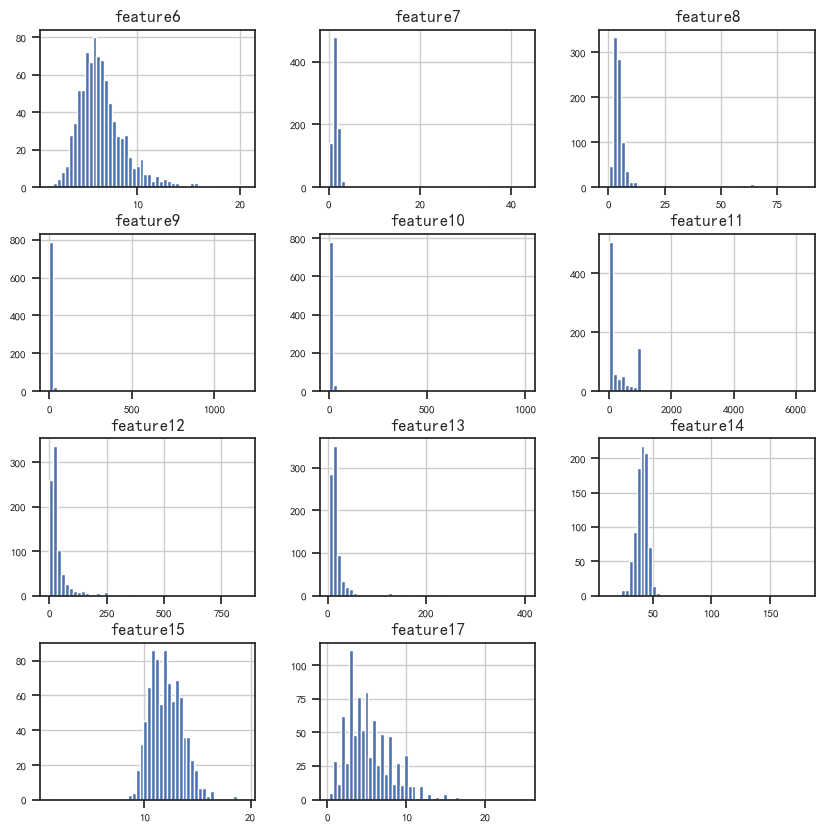

In [28]:
numerical_ftr = df.iloc[:, 3:].select_dtypes('float64').columns
categorical_ftr = df.iloc[:, 3:].select_dtypes('int64').columns

df[numerical_ftr].hist(figsize=(10, 10), bins=50, xlabelsize=8, ylabelsize=8)

# preprocess

## Get class label

In [ ]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

df = data.copy()
df['总体生存时间'] = df['总体生存时间'].apply(get_class)

In [ ]:
sns.barplot(y=df["总体生存时间"].value_counts().values, x=df["总体生存时间"].value_counts().index)
plt.title("Number of samples in each class")

In [ ]:
df.rename(columns={"总体生存时间": "target"}, inplace=True)

with_ = df[df["淋巴清扫"] == 1]
without_ = df[df["淋巴清扫"] == 0]

with_.drop(["淋巴清扫"], axis=1, inplace=True)
without_.drop(["淋巴清扫"], axis=1, inplace=True)
print(f'清扫组样本数：{len(with_)}\n未清扫组样本数：{len(without_)}')

### Nomalization

In [ ]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

def normalize(scaler, x, y):
    x = scaler.fit_transform(x)
    y = np.array(y)
    
    return x, y

with_x, with_y = normalize(scaler, with_.iloc[:, 1:], with_.iloc[:, 0])
without_x, without_y = normalize(scaler, without_.iloc[:, 1:], without_.iloc[:, 0])

# Model

In [ ]:
def clf_model_eval(model, x, y, TNM=True):
    K = 16
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    kf.get_n_splits(x)
    valid_acc = []
    valid_precision = []
    valid_recall = []
    valid_f1 = []
    valid_auc = []
    valid_prob = []

    # 多折交叉验证
    for train_idx, valid_idx in kf.split(x, y):
        train_x, valid_x = x[train_idx], x[valid_idx]
        train_y, valid_y = y[train_idx], y[valid_idx]
        model.fit(train_x, train_y)
        
        pred = model.predict(valid_x)
        proba = model.predict_proba(valid_x)
        
        valid_prob.append(proba)
        valid_acc.append(accuracy_score(valid_y, pred))
        valid_precision.append(precision_score(valid_y, pred, average="macro"))
        valid_recall.append(recall_score(valid_y, pred, average="macro"))
        valid_f1.append(f1_score(valid_y, pred, average="macro"))
        valid_auc.append(roc_auc_score(valid_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro'))
    
    # map函数返回一个map对象，需要转换
    valid_res = map(np.mean, [valid_acc, valid_precision, valid_recall, valid_f1, valid_auc])
    valid_prob = np.concatenate(valid_prob, axis=0)
    
    return list(valid_res), valid_prob

In [ ]:
clf = {
    "MLP": [
        MLPClassifier(learning_rate="adaptive", max_iter=500),
        MLPClassifier(learning_rate="adaptive", max_iter=500),
    ],
    "SVM": [SVC(probability=True), SVC(probability=True)],
    "RF": [RandomForestClassifier(), RandomForestClassifier()],
    "KNN": [KNeighborsClassifier(), KNeighborsClassifier()],
    "GBDT": [
        lgbm.LGBMClassifier(objective="multiclass"),
        lgbm.LGBMClassifier(objective="multiclass"),
    ],
}

# Results of classification

In [ ]:
with_proba = {}
without_proba = {}
with_result = {}
without_result = {}

for name, models in clf.items():
    test_res, proba = clf_model_eval(models[0], with_x, with_y)  # 清扫组模型
    with_result[name] = test_res
    with_proba[name] = proba

for name, models in clf.items():
    test_res, proba = clf_model_eval(models[1], without_x, without_y, TNM=False) # 未清扫组模型
    without_result[name] = test_res
    without_proba[name] = proba

清扫组结果：

In [ ]:
df1 = pd.DataFrame(with_result, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df1 = df1.T
df1

未清扫组结果：

In [ ]:
df2 = pd.DataFrame(without_result, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df2 = df2.T
df2

# Plot

针对多类数据的ROC曲线的可视化方式有两种：

第一种为：采用将原始数据的真实类别标签矩阵和模型预测得到的概率矩阵分别按行展开，转置后形成两列，这就可以近似的看作获得了一个二分类的结果，进而可以可视化ROC曲线。(micro)

第二种方式为：将每一类数据和其他类别的数据看作为一个二分类类的数据模型，然后对数据可视化ROC曲线。为了方便计算每一类样本的ROC曲线的相关取值，可以将类别标签使用label_binarize进行编码。（macro）

In [ ]:
def get_roc_data(pred_proba, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    bs = []
    for i in range(6):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        bs.append(brier_score_loss(y_test[:, i], pred_proba[:, i], pos_label=i))

    
    # micro
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(6):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # 平均AUC
    mean_tpr /= 6
    fpr = all_fpr
    tpr = mean_tpr
    auc_ = auc(fpr, tpr)
    return fpr, tpr, auc_, roc_auc, bs

In [ ]:
with_y_ = label_binarize(with_y, classes=[0, 1, 2, 3, 4, 5])
without_y_ = label_binarize(without_y, classes=[0, 1, 2, 3, 4, 5])

w_fpr, wo_fpr = {}, {}
w_tpr, wo_tpr = {}, {}
w_auc, wo_auc = {}, {}
w_cindex, wo_cindex = {}, {}
w_bs, wo_bs = {}, {}

for name, pred_proba in with_proba.items():
    w_fpr[name], w_tpr[name], w_auc[name], w_cindex[name], w_bs[name] = get_roc_data(pred_proba, with_y_)

for name, pred_proba in without_proba.items():
    wo_fpr[name], wo_tpr[name], wo_auc[name], wo_cindex[name], wo_bs[name] = get_roc_data(pred_proba, without_y_)

## ROC

In [ ]:
def draw_roc(fpr, tpr, roc_auc, switch=True):
    plt.figure()
    lw = 2
    # colors = plt.cm.get_cmap("Dark2")
    plt.plot(
        fpr["MLP"],tpr["MLP"],lw=lw,label="MLP (AUC = %0.2f)" % roc_auc["MLP"],
    )
    plt.plot(
        fpr["SVM"],tpr["SVM"],lw=lw,label="SVM (AUC = %0.2f)" % roc_auc["SVM"],
    )
    plt.plot(
        fpr["RF"],tpr["RF"],lw=lw,label="RF (AUC = %0.2f)" % roc_auc["RF"],
    )
    plt.plot(
        fpr["KNN"],tpr["KNN"],lw=lw,label="KNN (AUC = %0.2f)" % roc_auc["KNN"],
    )
    plt.plot(
        fpr["GBDT"],tpr["GBDT"],lw=lw,label="GBDT (AUC = %0.2f)" % roc_auc["GBDT"],
    )
    plt.plot([0, 1], [0, 1], color="#9DA9B4", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    if switch:
        plt.title(f"ROC Curve of Different Models (LND)", fontsize=16)
        # plt.savefig('./imgs/ROC-LND.svg')
    else:
        plt.title("ROC Curve of Different Models (nLND)", fontsize=16)
        # plt.savefig('./imgs/ROC-nLND.svg')
    plt.show()

In [ ]:
draw_roc(w_fpr, w_tpr, w_auc)   # with

In [ ]:
draw_roc(wo_fpr, wo_tpr, wo_auc, switch=False)  # without

## Discrimination and Calibration

In [ ]:
plt.figure()
# w_cindex
# plt.plot(w_cindex["MLP"].values(), "o-", label="MLP")
# plt.plot(w_cindex["SVM"].values(), "o-", label="SVM")
# plt.plot(w_cindex["RF"].values(), "o-", label="RF")
# plt.plot(w_cindex["KNN"].values(), "o-", label="KNN")
# plt.plot(w_cindex["GBDT"].values(), "o-", label="GBDT")
# plt.title("Discrimination of different models (LND)")
# xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
# plt.xticks(range(0, 6), xlabel)
# plt.ylim([0.0, 1.05])
# plt.legend()
# plt.savefig('./imgs/discrimination-LND.svg')

# wo_cindex
plt.plot(wo_cindex["MLP"].values(), "o-", label="MLP")
plt.plot(wo_cindex["SVM"].values(), "o-", label="SVM")
plt.plot(wo_cindex["RF"].values(), "o-", label="RF")
plt.plot(wo_cindex["KNN"].values(), "o-", label="KNN")
plt.plot(wo_cindex["GBDT"].values(), "o-", label="GBDT")
plt.title("Discrimination of different models (nLND)")
xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
plt.xticks(range(0, 6), xlabel)
plt.ylim([0.0, 1.05])
plt.legend()
# plt.savefig('./imgs/discrimination-nLND.svg')

plt.show()

In [ ]:
# w_bs
# plt.plot(w_bs["MLP"], "o-", label="MLP")
# plt.plot(w_bs["SVM"], "o-", label="SVM")
# plt.plot(w_bs["RF"], "o-", label="RF")
# plt.plot(w_bs["KNN"], "o-", label="KNN")
# plt.plot(w_bs["GBDT"], "o-", label="GBDT")
# plt.title("Calibration of different models (LND)")
# xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
# plt.xticks(range(0, 6), xlabel)
# plt.legend()
# plt.savefig('./imgs/calibration-LND.svg')

# wo_bs
plt.plot(wo_bs["MLP"], "o-", label="MLP")
plt.plot(wo_bs["SVM"], "o-", label="SVM")
plt.plot(wo_bs["RF"], "o-", label="RF")
plt.plot(wo_bs["KNN"], "o-", label="KNN")
plt.plot(wo_bs["GBDT"], "o-", label="GBDT")
plt.title("Calibration of different models (nLND)")
xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
plt.xticks(range(0, 6), xlabel)
plt.legend()
# plt.savefig('./imgs/calibration-nLND.svg')

plt.show()

# SHAP

使用清扫组数据进行机器学习模型可解释性探索

In [ ]:
import shap
shap.initjs()
ftr_names = with_.columns[1:]

X = with_.iloc[:, 1:]
explainer = shap.TreeExplainer(clf['GBDT'][0])
# X = without_.iloc[:, 1:]
# explainer = shap.TreeExplainer(clf['GBDT'][1])

shap_values = explainer.shap_values(X)

6类  
244个训练样本  
23项特征

In [ ]:
# print(len(shap_values))
# print(shap_values[0].shape)

概括图，该图是对全部样本全部特征的shap值进行求和，可以反映出特征重要性及每个特征对样本类别预测的贡献。
- 对每个特征的SHAP值取绝对值平均，得到特征重要性分布

**对LND组模型进行特征重要性排序：**

In [ ]:
shap.summary_plot(shap_values, X, show=False)
# # plt.savefig('./imgs/ftr_importance-LND.svg')
# # plt.savefig('./imgs/ftr_importance-nLND.svg')